In [10]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm import tqdm
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms.functional as F
from fly_dataset import FLYDataset
from fly_cnn_old import CNN_Fly

In [11]:
class ResNet50Keypoints(nn.Module):
    def __init__(self, num_joints=38):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Replace final classification layer with regression head
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_joints * 2)
        )

        self.num_joints = num_joints

    def forward(self, x):
        out = self.backbone(x)               # shape: [B, num_joints * 2]
        out = out.view(-1, self.num_joints, 2)  # shape: [B, J, 2]
        return out


Used Device: cuda:0


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 3, 480, 960] to have 1 channels, but got 3 channels instead

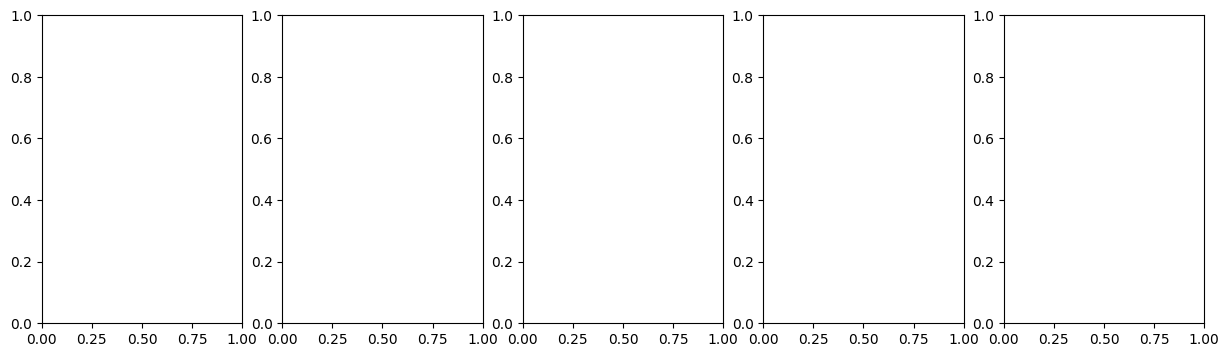

In [14]:
# Visualize model
def visualize_predictions(model, dataset, device="cuda", num_samples=5):
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    axes = axes if num_samples > 1 else [axes]

    for i in range(num_samples):
        img, true_kp = dataset[i]
        # Since the model expects a batch, we unsqueeze to create a "batch" 
        # consisting of a single image.
        #input_img = img.unsqueeze(0).to(device)  # [1, 3, H, W]
        img.to(device)
        
        # Permute to get from [C, H, W] to [H, W, 3]
        vis_img = img.permute(1, 2, 0).cpu().numpy() 

        # Run model
        with torch.no_grad():
            # Model returns a batch, meaning [B, J, 2], with squeezing 0 we 
            # end up with [J, 2].
            pred_kp, _, _, _ = model(img).cpu() 

        # Get H, W from the visualize image shape. We permuted earlier, 
        # meaning now we just cut of the last dim to end up with [H, W].
        H, W = vis_img.shape[:2]
        pred_px = pred_kp.clone()
        pred_px[:, 0] *= H
        pred_px[:, 1] *= W

        true_px = true_kp.clone()
        true_px[:, 0] *= H
        true_px[:, 1] *= W

        ax = axes[i]
        ax.imshow(vis_img)
        valid_pred = (
            (pred_px[:, 0] >= 0) & (pred_px[:, 0] < H) &
            (pred_px[:, 1] >= 0) & (pred_px[:, 1] < W)
        )
        pred_px = pred_px[valid_pred]
        valid_true = (
            (true_px[:, 0] >= 0) & (true_px[:, 0] < H) &
            (true_px[:, 1] >= 0) & (true_px[:, 1] < W)
        )
        true_px = true_px[valid_true]
        ax.scatter(pred_px[:, 1], pred_px[:, 0], c='r', label='Predicted', s=10)
        ax.scatter(true_px[:, 1], true_px[:, 0], c='g', label='GT', s=10, alpha=0.6)
        ax.set_title(f"Sample {i}")
        ax.axis("off")

    plt.tight_layout()
    axes[0].legend()
    plt.show()


# Pre-Trained ResNet50 Model (ImageNet) to have a better starting point 
model = CNN_Fly((480, 960), 32)
test_dataset = FLYDataset("/scratch/cv-course2025/group2/data", mode="test")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use CPU for debug so you do not use too much GPU time
print(f"Used Device: {device}")

model.load_state_dict(torch.load("/scratch/cv-course2025/group2/uzk_cvproject/fly-test-resnet50.pt"))
model.to(device)
visualize_predictions(model, test_dataset, device=device)